In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src import *
from model.classification import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [4]:
def extract_single_events(signal, events, config):
    valid_events = []
    for event in events:
        events_after_mask = events >= event - config.window_length / 2
        events_before_mask = events < event + config.window_length / 2

        E = np.sum(events_after_mask & events_before_mask)
        if E == 1:
            valid_events.append(event)

    signals = []
    for event in valid_events:
        from_time = event - config.window_length / 2
        till_time = event + config.window_length / 2
        from_sample = round(from_time * config.sr)
        till_sample = round(till_time * config.sr)

        s = signal[from_sample: till_sample]
        signals.append(s)
    return signals

In [5]:
files = [
    '12_RX100',
    '12_iphone',
    '12_Mobius'
]

In [6]:
file = files[0]
signal = load_audio(file)

In [7]:
signal

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0083, 0.0073, 0.0060])

In [8]:
model, config = load_model_locally('one_location', 'rvce', device='cpu')
datapool = DataPool(files, config.window_length, config.split_ratio, tqdm=tqdm)
# signal = datapool[file].signal
# events = datapool[file].events
# samples, labels = create_dataset_sequentially(signal, config.sr, events, window_length=config.window_length)

Video loading:   0%|          | 0/3 [00:00<?, ?it/s]

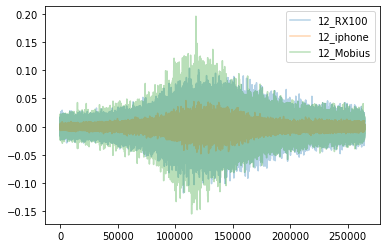

In [9]:
for file, video in datapool.items(): 
    signal = video.signal
    events = video.events
    
    signals = extract_single_events(signal, events, config)
    signals = torch.stack(signals, dim=0)
    
    mean_signal = 0
    for signal in signals:
        mean_signal += signal
    mean_signal /= len(signals)
    
    plt.plot(mean_signal, label=file, alpha=0.33)
    
plt.legend();

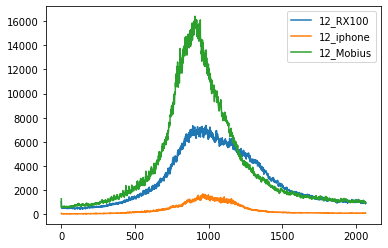

In [22]:
mean_energies = []
statistics = []
for file, video in datapool.items(): 
#     file = '12_RX100'
    signal = video.signal
    events = video.events
    
    signals = extract_single_events(signal, events, config)
    signals = torch.stack(signals, dim=0)
    
    mean_energy = 0
    energies = []
    for signal in signals:
        features = torch.stft(signal, n_fft=config.n_fft, hop_length=config.hop_length)
        energy = features[..., 0].pow(2)
        energy = energy.sum(0)
        mean_energy += energy
#         print(spectrogram(signal).min())

        energies.append(energy.sum())

    statistics.append([file, np.mean(energies), np.std(energies)])
    
    mean_energy = mean_energy / len(signals)
    mean_energies.append(mean_energy)
    plt.plot(mean_energy, label=file)
plt.legend();

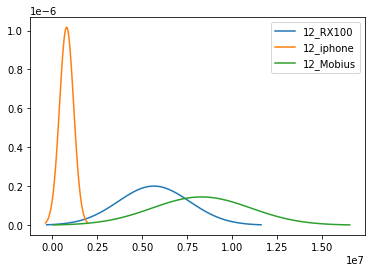

In [23]:
import scipy.stats as stats
for file, mu, std in statistics:
    x = np.linspace(mu - 3 * std, mu + 3 * std, 100)
    plt.plot(x, stats.norm.pdf(x, mu, std), label=file);
plt.legend();

In [44]:
def optimize(target_mean, target_std, datapool, files):
    p = torch.distributions.Normal(target_mean, target_std)

    coefficients = []
    means = []
    stds = []
    for file in files: 
        video = datapool[file]
        signal = video.signal
        events = video.events
        
        signals = extract_single_events(signal, events, config)
        signals = torch.stack(signals, dim=0)

        loss_min = np.inf
        mean_best = None
        std_best = None
        coefficient_best = None

        for coefficient in np.arange(0.1, 5, 0.05):
            coefficient * signals
            energies = torch.stft(coefficient * signals, n_fft=config.n_fft, hop_length=config.hop_length)[..., 0].pow(2).sum((1, 2))
            mean = energies.mean()
            std = energies.std()

            q = torch.distributions.Normal(mean, std)
            loss = torch.distributions.kl_divergence(p, q).mean()

            if loss < loss_min:
                loss_min = loss
                mean_best = mean
                std_best = std
                coefficient_best = coefficient

        coefficients.append(coefficient_best)
        means.append(mean_best)
        stds.append(std_best)
        
    return coefficients, means, stds

file, mean, std = statistics[0]
coefficients, means, stds = optimize(mean, std, datapool, ['12_iphone', '12_Mobius'])

In [45]:
coefficients

[2.5500000000000007, 0.8500000000000002]

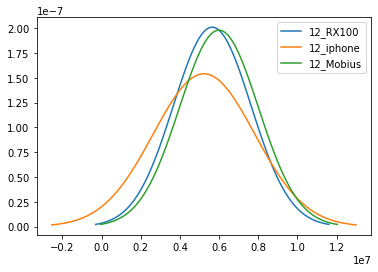

In [46]:
import scipy.stats as stats

file, mu, std = statistics[0]
x = np.linspace(mu - 3 * std, mu + 3 * std, 100)
plt.plot(x, stats.norm.pdf(x, mu, std), label=file);

for file, mu, std in zip(['12_iphone', '12_Mobius'], means, stds):
    x = np.linspace(mu - 3 * std, mu + 3 * std, 100)
    plt.plot(x, stats.norm.pdf(x, mu, std), label=file);

plt.legend();

### Optimize full transformation pipeline

In [58]:
model, config = load_model_locally('one_location', 'rvce', device='cpu')

In [71]:
def find_energies(signals, transform):
    energies = []
    for signal in signals:
        transform(signal).sum()
        energies.append(transform(signal).pow(2).sum())
    return np.array(energies)

def find_statistics(file, datapool, transform):
    video = datapool[file]

    signal = video.signal
    events = video.events
    
    signals = extract_single_events(signal, events, config)
    signals = torch.stack(signals, dim=0)
    
    energies = find_energies(signals, transform)

    return np.mean(energies), np.std(energies)


config.normalization = Normalization.NONE
transform = create_transformation(config)
mean_target, std_target = find_statistics('12_RX100', datapool, transform)
mean_1, std_1 = find_statistics('12_iphone', datapool, transform)
mean_2, std_2 = find_statistics('12_Mobius', datapool, transform)

In [72]:
mean_target

112443020.0

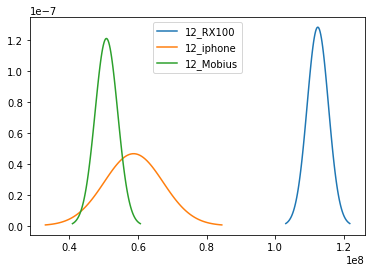

In [73]:
means = [mean_target, mean_1, mean_2]
stds = [std_target, std_1, std_2]

for file, mu, std in zip(files, means, stds):
    x = np.linspace(mu - 3 * std, mu + 3 * std, 100)
    plt.plot(x, stats.norm.pdf(x, mu, std), label=file);
plt.legend();

In [67]:
def optimize_file(target_mean, target_std, datapool, transform, file_to_optimize):

    video = datapool[file_to_optimize]
    signal = video.signal
    events = video.events
    
    signals = extract_single_events(signal, events, config)
    signals = torch.stack(signals, dim=0)

    loss_min = np.inf
    mean_best = None
    std_best = None
    coefficient_best = None

    p = torch.distributions.Normal(target_mean, target_std)

    for coefficient in np.arange(0.1, 5, 0.05):
        energies = find_energies(signals * coefficient, transform)
        mean = energies.mean()
        std = energies.std()

        q = torch.distributions.Normal(mean, std)
        loss = torch.distributions.kl_divergence(p, q).mean()

        if loss < loss_min:
            loss_min = loss
            mean_best = mean
            std_best = std
            coefficient_best = coefficient
        
    return coefficient_best, mean_best, std_best

config.normalization = Normalization.NONE
transform = create_transformation(config)
mean_target, std_target = find_statistics('12_RX100', datapool, transform)
coefficient_1_best, mean_1_best, std_1_best = optimize_file(mean_target, std_target, datapool, transform, '12_iphone')
coefficient_2_best, mean_2_best, std_2_best = optimize_file(mean_target, std_target, datapool, transform, '12_Mobius')

In [68]:
coefficient_1_best, coefficient_2_best

(1.8000000000000007, 0.6000000000000002)

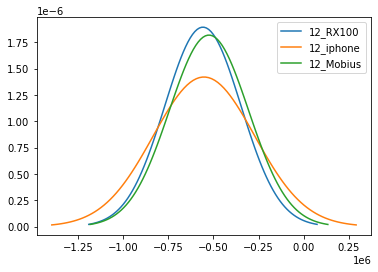

In [69]:
means = [mean_target, mean_1_best, mean_2_best]
stds = [std_target, std_1_best, std_2_best]

for file, mu, std in zip(files, means, stds):
    x = np.linspace(mu - 3 * std, mu + 3 * std, 100)
    plt.plot(x, stats.norm.pdf(x, mu, std), label=file);
plt.legend();

In [55]:
mean_1, std_1

(0.00054006866, 0.0041665733)

In [56]:
mean_2, std_2

(0.00012576941, 0.0017117525)

5.800000000000001


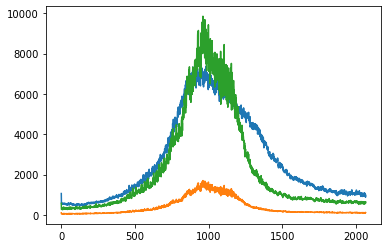

In [10]:
plt.plot(mean_energies[0])
plt.plot(mean_energies[1])

loss_best = np.inf
coefficient_best = None
for coefficient in np.arange(0, 10, 0.1):
    
    loss = (mean_energies[1] * coefficient - mean_energies[0]).pow(2).mean()
    if loss < loss_best:
        loss_best = loss
        coefficient_best = coefficient

print(coefficient_best)
plt.plot(mean_energies[1] * coefficient_best);

12_RX100
12_iphone
12_Mobius


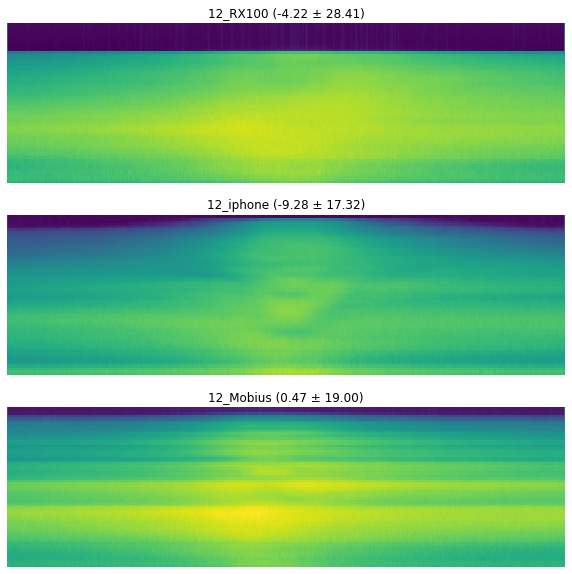

In [13]:
config.normalization = Normalization.NONE

transform = create_transformation(config)

n_videos = len(datapool)

fig, axes = plt.subplots(n_videos, 1, figsize=(10,10))
mean_features = []
vmin = np.inf
vmax = -np.inf

for i, (file, video) in enumerate(datapool.items()): 
    signal = video.signal
    events = video.events
    
    signals = extract_single_events(signal, events, config)
    signals = torch.stack(signals, dim=0)
    
    mean_feature = 0
#     transform(signal)[0]
    for signal in signals:
        mean_feature += transform(signal)[0]
    
    mean_feature = mean_feature / len(signals)
    print(file)
    mean_features.append(mean_feature)
    vmin = min(mean_feature.min(), vmin)
    vmax = max(mean_feature.max(), vmax)
    
for i, file in enumerate(datapool.keys()):
    feature = mean_features[i]
    axes[i].set_title(f'{file} ({feature.mean():.2f} ± {feature.std():.2f})')
    axes[i].pcolormesh(feature, vmin=vmin, vmax=vmax)
    axes[i].axis('off')

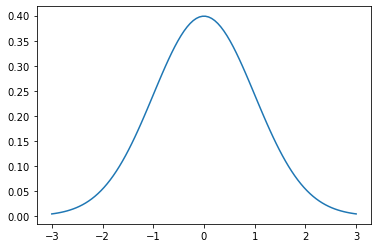

In [15]:
import scipy.stats as stats

mu = 0
var = 1
std = math.sqrt(var)
x = np.linspace(mu - 3 * std, mu + 3 * std, 100)
plt.plot(x, stats.norm.pdf(x, mu, std));

tensor(244269.5781)
tensor(977078.3125)
tensor(2198426.5000)
tensor(3908313.2500)


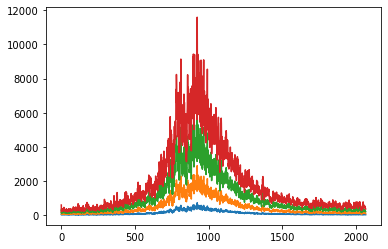

In [185]:
energies = []
for i in range(1, 5):
    features = torch.stft(i * mean_signal, n_fft=config.n_fft, hop_length=config.hop_length)
    energy = features[..., 0].pow(2)
    energy = energy.sum(0)
    energies.append(energy)

    plt.plot(energy)
    print(energy.sum())

In [193]:
config.normalization = Normalization.GLOBAL
transform = create_transformation(config)

for i in range(1, 20):
    x = transform(i * mean_signal).abs().sum()
    print(x)

tensor(96824.2734)
tensor(96824.2734)
tensor(96824.2656)
tensor(96824.2734)
tensor(96824.2500)
tensor(96824.2656)
tensor(96824.2500)
tensor(96824.2734)
tensor(96824.2656)
tensor(96824.2500)
tensor(96824.2656)
tensor(96824.2656)
tensor(96824.2656)
tensor(96824.2500)
tensor(96824.2656)
tensor(96824.2734)
tensor(96824.2656)
tensor(96824.2656)
tensor(96824.2500)
